In [ ]:
!pip install textdistance
!pip install Augmentor
!pip install wandb

     |████████████████████████████████| 1.8 MB 4.0 MB/s 
     |████████████████████████████████| 144 kB 23.4 MB/s 
     |████████████████████████████████| 181 kB 6.6 MB/s 
     |████████████████████████████████| 63 kB 1.1 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=bf05d3a7cd4880f629a57644e74e57a9b346c7a4b0470de5e22b3e8431d59eb0
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [ ]:
import os
import time
import math
import random
import pandas as pd
import numpy as np
import torch
import torchvision
from torch import nn
from torch.nn import Conv2d, MaxPool2d, BatchNorm2d, ReLU, LeakyReLU
from torch.utils.data import Dataset, sampler
from torch.nn.utils.clip_grad import clip_grad_norm_
from torchvision import models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from textdistance import levenshtein as lev
import cv2
from datetime import datetime
import csv
import wandb
from collections import Counter

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mkdir './HTR_dataset'
!mkdir './HTR_dataset/test_journal'
!cp '/content/drive/MyDrive/JOURNAL_HCR_PROJECT/HTR_dataset/train.tsv' './HTR_dataset/train.tsv'
!cp '/content/drive/MyDrive/JOURNAL_HCR_PROJECT/HTR_dataset/test.tsv' './HTR_dataset/test.tsv'
!cp '/content/drive/MyDrive/JOURNAL_HCR_PROJECT/HTR_dataset/train_filtered.csv' './HTR_dataset/train_filtered.csv'
!cp '/content/drive/MyDrive/JOURNAL_HCR_PROJECT/HTR_dataset/chars_code.csv' './HTR_dataset/chars_code.csv'
!cp '/content/drive/MyDrive/JOURNAL_HCR_PROJECT/HTR_dataset/train.zip' './HTR_dataset/train.zip'
!cp '/content/drive/MyDrive/JOURNAL_HCR_PROJECT/HTR_dataset/test.zip' './HTR_dataset/test.zip'
!cp '/content/drive/MyDrive/JOURNAL_HCR_PROJECT/HTR_dataset/source.txt' './HTR_dataset/gen_source.txt'
!cp '/content/drive/MyDrive/JOURNAL_HCR_PROJECT/HTR_dataset/source_valid.txt' './HTR_dataset/gen_source_valid.txt'
!cp '/content/drive/MyDrive/JOURNAL_HCR_PROJECT/Names_test_dataset.zip' './HTR_dataset/test_journal.zip'
!cp '/content/drive/MyDrive/JOURNAL_HCR_PROJECT/Grades Dataset.zip' './HTR_dataset/grades_data.zip'
!unzip './HTR_dataset/train.zip' -d './HTR_dataset'
!unzip './HTR_dataset/test.zip' -d './HTR_dataset'
!unzip './HTR_dataset/test_journal.zip' -d './HTR_dataset'
!unzip './HTR_dataset/grades_data.zip' -d './HTR_dataset'

Streaming output truncated to the last 5000 lines.
 extracting: ./HTR_dataset/train/vb219.png  
  inflating: ./HTR_dataset/train/az7086.png  
  inflating: ./HTR_dataset/train/auu853.png  
  inflating: ./HTR_dataset/train/rc1056.png  
  inflating: ./HTR_dataset/train/rc4170.png  
  inflating: ./HTR_dataset/train/as2845.png  
  inflating: ./HTR_dataset/train/rc777.png  
  inflating: ./HTR_dataset/train/iy171.png  
 extracting: ./HTR_dataset/train/as5611.png  
  inflating: ./HTR_dataset/train/ao10768.png  
  inflating: ./HTR_dataset/train/ahh298.png  
  inflating: ./HTR_dataset/train/rc1491.png  
  inflating: ./HTR_dataset/train/ap64.png  
  inflating: ./HTR_dataset/train/ahh340.png  
 extracting: ./HTR_dataset/train/aq66.png  
 extracting: ./HTR_dataset/train/aq2481.png  
  inflating: ./HTR_dataset/train/ab2108.png  
  inflating: ./HTR_dataset/train/ab6418.png  
  inflating: ./HTR_dataset/train/rc1835.png  
  inflating: ./HTR_dataset/train/as15416.png  
  inflating: ./HTR_dataset/train/a

## CONFIG

In [ ]:
WANDB_LOG = True
FINISH_TRAINING = True
GENERAL_RESULT_DIR = '/content/drive/MyDrive/JOURNAL_HCR_PROJECT/training_results/'

if FINISH_TRAINING:
    date_dirs_name = []
    for dir_name in os.listdir(GENERAL_RESULT_DIR):
        try:
            time.strptime(dir_name, '%Y-%m-%d_%H:%M:%S')
            date_dirs_name.append(dir_name)
        except ValueError:
            continue
    last_training_name = date_dirs_name[-1]
    RESULT_DIRECTORY = os.path.join(GENERAL_RESULT_DIR, last_training_name) 
else: 
    now = datetime.now()
    current_time = now.strftime('%Y-%m-%d_%H:%M:%S')
    RESULT_DIRECTORY = os.path.join(GENERAL_RESULT_DIR, current_time) 
    os.mkdir(RESULT_DIRECTORY)

RESULT_DIRECTORY

'/content/drive/MyDrive/JOURNAL_HCR_PROJECT/training_results/2022-04-23_06:52:11'

In [ ]:
!mkdir ./checkpoints/

ALPHABET = " !%(),-./0123456789:;?[]«»АБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩЭЮЯабвгдежзийклмнопрстуфхцчшщъыьэюяё"
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
REPORT_ACCURACY = True
PATH_TO_TRAIN_ = "/content/HTR_dataset/train/"
PATH_TO_TRAIN_LABELS = "/content/HTR_dataset/train_filtered.csv"
PATH_TO_TEST_ = "/content/HTR_dataset/test/"
PATH_TO_TEST_LABELS = "/content/HTR_dataset/test.tsv"
PATH_TO_CHECKPOINT = "./checkpoints/"
APPLY_AUGS = True # is augmentation applied?
SEED = 41
BATCH_SIZE = 40
LRATE = 0.0002

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

mkdir: cannot create directory ‘./checkpoints/’: File exists


## MODELS

### MODEL 1

"An End-to-End Trainable Neural Network for Image-based Sequence Recognition and Its Application to Scene Text Recognition" https://arxiv.org/abs/1507.05717

In [ ]:
class BidirectionalLSTM(nn.Module):

    def __init__(self, nIn, nHidden, nOut):
        super(BidirectionalLSTM, self).__init__()
        self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True)
        self.embedding = nn.Linear(nHidden * 2, nOut)
    def forward(self, input):
        self.rnn.flatten_parameters()
        recurrent, _ = self.rnn(input)
        T, b, h = recurrent.size()
        t_rec = recurrent.view(T * b, h)
        output = self.embedding(t_rec)  # [T * b, nOut]
        output = output.view(T, b, -1)
        return output

class Model1(nn.Module):

    def __init__(self, nHidden, num_classes):
        super(Model1, self).__init__()

        self.conv0 = Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.conv1 = Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv5 = Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.conv6 = Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.conv7 = Conv2d(512, 512, kernel_size=7, stride=1, padding=1)

        self.pool1 = MaxPool2d(kernel_size=2, stride=2)
        self.pool2 = MaxPool2d(kernel_size=2, stride=(2,1))
        self.pool3 = MaxPool2d(kernel_size=2, stride=(2,1))
        self.pool4 = MaxPool2d(kernel_size=2, stride=(3,1))

        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn4 = nn.BatchNorm2d(512)

        self.rnn = nn.Sequential(
            BidirectionalLSTM(nHidden*2, nHidden, nHidden),
            BidirectionalLSTM(nHidden, nHidden, len(ALPHABET)))


    def forward(self, src):
        '''
        src : [b, c, h, w]
        '''
        x = self.conv0(src)
        x = self.bn1(self.pool1(self.conv1(x)))
        x = self.conv2(x)
        x = self.bn2(self.pool2(self.conv3(x)))
        x = self.conv4(x)
        x = self.bn3(self.pool3(self.conv5(x)))
        x = self.conv6(x)
        x = self.bn4(self.pool4(self.conv7(x)))
        b, c, h, w = x.size() # [4, 512, 1, 121])
        assert h == 1, "the height of conv must be 1"
        x = x.squeeze(2) # [b, c, h*w]
        x = x.permute(2, 0, 1)  # [h*w, b, c]
        logits = self.rnn(x) # [h*w, b, num_classes]
        output = torch.nn.functional.log_softmax(logits, 2)
        return output

### MODEL 2: ResNet50 + LSTM

In [ ]:
class Model2(nn.Module):

    def __init__(self, nHidden, num_classes):
        super(Model2, self).__init__()
        self.resnet50 = models.resnet50(pretrained=True)
        self.resnet50.fc1 = nn.Conv2d(2048, 512, kernel_size=(2, 2))
        self.resnet50.fc2 = nn.Linear(8, 16)

        self.rnn = nn.Sequential(
            BidirectionalLSTM(nHidden*2, nHidden, nHidden),
            BidirectionalLSTM(nHidden, nHidden, num_classes))


    def forward(self, src):
        # ResNet requires 3 channels
        if src.shape[1] == 1:
          src = src.repeat(1, 3, 1, 1)
        x = self.resnet50.conv1(src)
        x = self.resnet50.bn1(x)
        x = self.resnet50.relu(x)
        x = self.resnet50.maxpool(x)
        x = self.resnet50.layer1(x)
        x = self.resnet50.layer2(x)
        x = self.resnet50.layer3(x)
        x = self.resnet50.layer4(x)
        x = self.resnet50.fc1(x)
        b, c, h, w = x.size()
        assert h == 1, "the height of conv must be 1"
        x = x.squeeze(2) # [b, c, h*w]
        x = x.permute(2, 0, 1)  # [h*w, b, c]
        logits = self.rnn(x) # [h*w, b, num_classes]
        output = torch.nn.functional.log_softmax(logits, 2)
        return output

### MODEL 3 


In [ ]:
class BidirectionalLSTM(nn.Module):

    def __init__(self, nIn, nHidden, nOut):
        super(BidirectionalLSTM, self).__init__()
        self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True)
        self.embedding = nn.Linear(nHidden * 2, nOut)
    def forward(self, input):
        self.rnn.flatten_parameters()
        recurrent, _ = self.rnn(input)
        T, b, h = recurrent.size()
        t_rec = recurrent.view(T * b, h)
        output = self.embedding(t_rec)  # [T * b, nOut]
        output = output.view(T, b, -1)
        return output

class Model3(nn.Module):

    def __init__(self, nHidden, num_classes):
        super(Model3, self).__init__()

        self.conv0 = Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv1 = Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv2 = Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv3 = Conv2d(256, 256, kernel_size=(3, 5), stride=(1, 1), padding=(1, 1))
        self.conv4 = Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv5 = Conv2d(512, 512, kernel_size=(3, 5), stride=(1, 1), padding=(1, 1))
        self.conv6 = Conv2d(512, 512, kernel_size=(4, 7), stride=(1, 1))

        self.pool0 = MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        self.pool1 = MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        self.pool3 = MaxPool2d(kernel_size=(2, 2), stride=(2, 1), padding=(0, 1), dilation=1, ceil_mode=False)
        self.pool5 = MaxPool2d(kernel_size=(2, 2), stride=(2, 1), padding=(0, 1), dilation=1, ceil_mode=False)

        self.bn2 = BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.bn4 = BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.bn6 = BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

        self.relu = ReLU()

        self.rnn = nn.Sequential(
            BidirectionalLSTM(nHidden*2, nHidden, nHidden),
            BidirectionalLSTM(nHidden, nHidden, nHidden),
            BidirectionalLSTM(nHidden, nHidden, num_classes))


    def forward(self, src):
        x = self.pool0(self.relu(self.conv0(src)))
        x = self.pool1(self.relu(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool3(self.relu(self.conv3(x)))
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.pool5(self.relu(self.conv5(x)))
        x = self.relu(self.bn6(self.conv6(x)))

        b, c, h, w = x.size()
        assert h == 1, "the height of conv must be 1"
        x = x.squeeze(2) # [b, c, h*w]
        x = x.permute(2, 0, 1)  # [h*w, b, c]
        logits = self.rnn(x) # [h*w, b, num_classes]
        output = torch.nn.functional.log_softmax(logits, 2)

        return output

### MODEL 4

"Fine-tuning Handwriting Recognition systems with Temporal Dropout" https://arxiv.org/pdf/2102.00511v1.pdf

In [ ]:
def TemporalDropout(x, p = 0.2):
    B, C, WH = x.shape # BATCH_SIZE, CHANNELS, WIDTH*HEIGHT
    v = torch.ones(size=(WH,))
    for k in range(int(C*p)):
      i = random.randint(0,WH-1)
      v[i] = 0
    mask = torch.stack([v]*C).to(DEVICE)
    x = x*mask
    return x

class Model4(nn.Module):

    def __init__(self, nHidden, num_classes):
        super(Model4, self).__init__()

        self.act = LeakyReLU(negative_slope=0.01, inplace=False)
        self.conv0 = Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.conv1 = Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv5 = Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.conv6 = Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.conv7 = Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.conv8 = Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.conv9 = Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.conv10 = Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.conv11 = Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.conv12 = Conv2d(512, 512, kernel_size=4, stride=1, padding=1)

        self.pool1 = MaxPool2d(kernel_size=2, stride=2)
        self.pool2 = MaxPool2d(kernel_size=2, stride=2)
        self.pool3 = MaxPool2d(kernel_size=(2,1), stride=(2,1))
        self.pool4 = MaxPool2d(kernel_size=(2,1), stride=(2,1))
        self.pool5 = MaxPool2d(kernel_size=(2,1), stride=(2,1))

        self.bn1 = BatchNorm2d(64)
        self.bn2 = BatchNorm2d(128)
        self.bn3 = BatchNorm2d(256)
        self.bn4 = BatchNorm2d(512)

        self.rnn1 = BidirectionalLSTM(2*nHidden, nHidden, num_classes, num_layers=3)
        self.rnn2 = BidirectionalLSTM(2*nHidden, nHidden, num_classes, num_layers=3)


    def forward(self, src):
        
        x = self.act(self.bn1(self.conv0(src)))
        x = self.act(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = self.act(self.bn2(self.conv2(x)))
        x = self.act(self.bn2(self.conv3(x)))
        x = self.pool2(x)
        x = self.act(self.bn3(self.conv4(x)))
        x = self.act(self.bn3(self.conv5(x)))
        x = self.act(self.bn3(self.conv6(x)))
        x = self.pool3(x)
        x = self.act(self.bn4(self.conv7(x)))
        x = self.act(self.bn4(self.conv8(x)))
        x = self.act(self.bn4(self.conv9(x)))
        x = self.pool4(x)
        x = self.act(self.bn4(self.conv10(x)))
        x = self.act(self.bn4(self.conv11(x)))
        x = self.act(self.bn4(self.conv12(x)))
        x = self.pool5(x)
        b, c, h, w = x.size()
        assert h == 1, "the height of conv must be 1"
        x = x.squeeze(2) # [b, c, h*w]
        x = TemporalDropout(x, 0.2)
        x = x.permute(2, 0, 1)  # [h*w, b, c]
        output1 = self.rnn1(x)
        output2 = self.rnn2(x)
        output = torch.cat([output1, output2], 0)
        output = torch.nn.functional.log_softmax(output, 2)
        return output

In [ ]:
def get_resnet_backbone(pretrained = True):
    m = torchvision.models.resnet50(pretrained=True)
    input_conv = nn.Conv2d(3, 64, 7, 1, 3)
    blocks = [input_conv, m.bn1, m.relu, m.maxpool, m.layer1, m.layer2, m.layer3, m.layer4]

    return nn.Sequential(*blocks)

class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout = 0.1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                    dropout = dropout, batch_first=True, bidirectional = True)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        return out

class CRNN(nn.Module):
    def __init__(self, number_class_symbols, time_feature_count = 256, lstm_hidden = 256, lstm_len = 3):
        super().__init__()
        self.feature_extractor = get_resnet_backbone(pretrained=True)
        self.avg_pool = nn.AdaptiveAvgPool2d((time_feature_count, time_feature_count))
        self.bilstm1 = BidirectionalLSTM(time_feature_count, lstm_hidden, time_feature_count)
        self.bilstm2 = BiLSTM(time_feature_count, lstm_hidden, lstm_len)
        
        self.classifier = nn.Sequential(
            nn.Linear(lstm_hidden * 2, time_feature_count),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(time_feature_count, number_class_symbols))
        
    def forward(self, x):
        x = self.feature_extractor(x)
        b,c,h,w = x.size()
        x = x.view(b, c*h, w)
        x = self.avg_pool(x)
        x = x.transpose(1, 2)
        x = self.bilstm1(x)
        x = self.bilstm2(x)
        x = self.classifier(x)
        x = nn.functional.log_softmax(x, dim=2).permute(1, 0, 2)

        return x

### DATASET

In [ ]:
from torchvision.transforms.transforms import ToPILImage
# class for mapping symbols into indicies and vice versa
class LabelCoder(object):
    def __init__(self, alphabet, ignore_case=False):
        self.alphabet = alphabet
        self.char2idx = {}
        for i, char in enumerate(alphabet):
            self.char2idx[char] = i + 1
        self.char2idx[''] = 0

    def encode(self, text: str):
        length = []
        result = []
        for item in text:
            length.append(len(item))
            for char in item:
                if char in self.char2idx:
                    index = self.char2idx[char]
                else:
                    index = 0
                result.append(index)

        text = result
        return (torch.IntTensor(text), torch.IntTensor(length))

    def encode_for_softmax(self, text: str, batch_size, string_len):
        output_tensor = torch.zeros(batch_size, string_len)
        for i, item in enumerate(text):
            for j, char in enumerate(item):
                if char in self.char2idx:
                    index = self.char2idx[char]
                else:
                    index = 0
                output_tensor[i, j] = index

        return output_tensor.type(torch.LongTensor)


    def decode(self, t, length, raw=False):
        if length.numel() == 1:
            length = length[0]
            assert t.numel() == length, "text with length: {} does not match declared length: {}".format(t.numel(),
                                                                                                         length)
            if raw:
                return ''.join([self.alphabet[i - 1] for i in t])
            else:
                char_list = []
                for i in range(length):
                    if t[i] != 0 and (not (i > 0 and t[i - 1] == t[i])):
                        char_list.append(self.alphabet[t[i] - 1])
                return ''.join(char_list)
        else:
            # batch mode
            assert t.numel() == length.sum(), "texts with length: {} does not match declared length: {}".format(
                t.numel(), length.sum())
            texts = []
            index = 0
            for i in range(length.numel()):
                l = length[i]
                texts.append(
                    self.decode(t[index:index + l], torch.IntTensor([l]), raw=raw))
                index += l
            return texts

class OCRdataset(Dataset):
    def __init__(self, path_to_imgdir: str, path_to_labels: str, transform_list = None, separator = '\t'):
        super(OCRdataset, self).__init__()
        self.imgdir = path_to_imgdir
        self.df = pd.read_csv(path_to_labels, sep = separator, names = ['image_name', 'label'])
        self.image2label = [(os.path.join(self.imgdir,image), label) for image, label in zip(self.df['image_name'], self.df['label'])]
        if transform_list is None:
            transform_list =  [transforms.ToPILImage(),
                              transforms.Grayscale(1),
                                #transforms.Resize((64, 256)),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,))]
        self.transform = transforms.Compose(transform_list)
        self.collate_fn = Collator()

    def __len__(self):
        return len(self.image2label)

    def __getitem__(self, index):
        assert index <= len(self), 'index range error'
        image_path, label = self.image2label[index]
        img = Image.open(image_path)
        img = self.resize_image(img, (64, 340))
        img = self.transform(img)
        item = {'idx' : index, 'img': img, 'label': label}
        return item
    
    def resize_image(self, img, size):
        img = img.convert('RGB')
        img = np.asanyarray(img)
        w, h, _= img.shape
        new_w = size[0]
        new_h = int(h * (new_w / w))
        img = cv2.resize(img, (new_h, new_w))
        w, h, _ = img.shape

        img = img.astype('float32')

        new_h = size[1]
        if h < new_h:
            add_zeros = np.full((w, new_h - h, 3), img.mean())
            img = np.concatenate((img, add_zeros), axis=1)

        if h > new_h:
            img = cv2.resize(img, (new_h, new_w))

        return img.astype(np.uint8)

class Collator(object):
    
    def __call__(self, batch):
        width = [item['img'].shape[2] for item in batch]
        indexes = [item['idx'] for item in batch]
        imgs = torch.ones([len(batch), batch[0]['img'].shape[0], batch[0]['img'].shape[1], 
                           max(width)], dtype=torch.float32)
        for idx, item in enumerate(batch):
            try:
                imgs[idx, :, :, 0:item['img'].shape[2]] = item['img']
            except:
                print(imgs.shape)
        item = {'img': imgs, 'idx':indexes}
        if 'label' in batch[0].keys():
            labels = [item['label'] for item in batch]
            item['label'] = labels
        return item

## AUGMENTATIONS

The following augmentations are used:

1. *Vignetting*: a reduction of an image's brightness or saturation toward the periphery compared to the image center.

2. Lens Distortion

In [ ]:
import Augmentor


class Vignetting(object):
    def __init__(self,
                 p = 0.1,
                 ratio_min_dist=0.2,
                 range_vignette=(0.2, 0.8),
                 random_sign=False):
        self.ratio_min_dist = ratio_min_dist
        self.range_vignette = np.array(range_vignette)
        self.random_sign = random_sign
        self.p = p

    def __call__(self, X, Y=None):

        if np.random.binomial(1, self.p) == 0:
            return X 
        h, w = X.shape[1:]
        min_dist = np.array([h, w]) / 2 * np.random.random() * self.ratio_min_dist
        # create matrix of distance from the center on the two axis
        x, y = np.meshgrid(np.linspace(-w / 2, w / 2, w), np.linspace(-h / 2, h / 2, h))
        x, y = np.abs(x), np.abs(y)
        # create the vignette mask on the two axis
        x = (x - min_dist[0]) / (np.max(x) - min_dist[0])
        x = np.clip(x, 0, 1)
        y = (y - min_dist[1]) / (np.max(y) - min_dist[1])
        y = np.clip(y, 0, 1)
        # then get a random intensity of the vignette
        vignette = (x + y) / 2 * np.random.uniform(*self.range_vignette)
        vignette = np.tile(vignette[None, ...], [1, 1, 1])

        sign = 2 * (np.random.random() < 0.5) * (self.random_sign) - 1
        Z = X * (1 + sign * vignette)
        return Z


class LensDistortion(object):
    def __init__(self, p = 0.1 ,d_coef=(0.15, 0.05, 0.05, 0.05, 0.05)):
        self.d_coef = np.array(d_coef)
        self.p = p

    def __call__(self, X):
        if np.random.binomial(1, self.p) == 0:
            return X 

        # get the height and the width of the image
        h, w = X.shape[:2]

        # compute its diagonal
        f = (h ** 2 + w ** 2) ** 0.5

        # set the image projective to carrtesian dimension
        K = np.array([[f, 0, w / 2],
                      [0, f, h / 2],
                      [0, 0, 1]])

        d_coef = self.d_coef * np.random.random(5)  # value
        d_coef = d_coef * (2 * (np.random.random(5) < 0.5) - 1)  # sign
        # Generate new camera matrix from parameters
        M, _ = cv2.getOptimalNewCameraMatrix(K, d_coef, (w, h), 0)

        # Generate look-up tables for remapping the camera image
        remap = cv2.initUndistortRectifyMap(K, d_coef, None, M, (w, h), 5)

        # Remap the original image to a new image
        Z = cv2.remap(np.float32(X.numpy()), *remap, cv2.INTER_LINEAR)
        return torch.from_numpy(Z)
    


if APPLY_AUGS:
    transform_list = [
            transforms.ToPILImage(),
            #transforms.Grayscale(1),
            #transforms.Resize((64, 512)),
            transforms.RandomRotation(degrees=(-3, 3), fill=150),
            #transforms.transforms.GaussianBlur(3, sigma=(0.1, 1.5)), 
            transforms.ToTensor(),
            #Vignetting(p = 0.5),
            #LensDistortion(p = 0.1),
            transforms.Normalize((0.5,), (0.5,))
        ]
else:
    transform_list = None

In [ ]:
dataset = OCRdataset(PATH_TO_TRAIN_, PATH_TO_TRAIN_LABELS, transform_list = transform_list)
print(len(dataset))
collator = Collator()
train_loader = torch.utils.data.DataLoader(dataset, batch_size = BATCH_SIZE, collate_fn = collator, shuffle = True)

31578


Explore some examples

ValueError: ignored

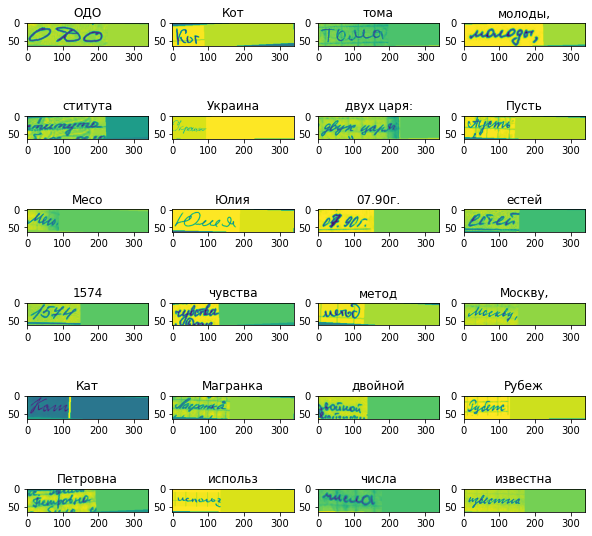

In [ ]:
examples = []
idx = 0

for batch in train_loader:
    img, true_label = batch['img'], batch['label']
    examples.append([img, true_label])
    idx += 1
    if idx == BATCH_SIZE:
        break
fig = plt.figure(figsize=(10, 10))
rows = int(16 / 4) + 2
columns = int(16 / 8) + 2
for j, exp in enumerate(examples):
    fig.add_subplot(rows, columns, j + 1)
    plt.imshow(exp[0][0].permute(1, 2, 0)[...,0])
    plt.title(exp[1][0])

In [ ]:
val_dataset = OCRdataset(PATH_TO_TEST_, PATH_TO_TEST_LABELS, transform_list = transform_list)
collator = Collator()
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = 8, collate_fn = collator)

# TRAIN

In [ ]:
class CustomCTCLoss(torch.nn.Module):
    # T x B x H => Softmax on dimension 2
    def __init__(self, dim=2):
        super().__init__()
        self.dim = dim
        self.ctc_loss = torch.nn.CTCLoss(reduction='mean', zero_infinity=True)

    def forward(self, logits, labels,
            prediction_sizes, target_sizes):
        EPS = 1e-7
        loss = self.ctc_loss(logits, labels, prediction_sizes, target_sizes)
        #loss = self.sanitize(loss)
        #return self.debug(loss, logits, labels, prediction_sizes, target_sizes)
        return loss
    
    def sanitize(self, loss):
        EPS = 1e-7
        if abs(loss.item()) > 99999:
            return torch.zeros_like(loss, requires_grad = True)
        if math.isnan(loss.item()):
            return torch.zeros_like(loss, requires_grad = True)
        return loss

    def debug(self, loss, logits, labels,
            prediction_sizes, target_sizes):
        if math.isnan(loss.item()):
            print("Loss:", loss)
            print("logits:", logits)
            print("labels:", labels)
            print("prediction_sizes:", prediction_sizes)
            print("target_sizes:", target_sizes)
            raise Exception("NaN loss obtained.")
        return loss


    
def print_epoch_data(epoch, 
                     mean_loss, 
                     char_error, 
                     word_error,
                     val_char_error,
                     val_word_error,
                     time_elapsed, 
                     zero_out_losses):
    if epoch == 0:
        print('epoch | mean loss | mean cer | mean wer | mean val_cer | mean val_wer | time elapsed | warnings')
    epoch_str = str(epoch)
    zero_out_losses_str = str(zero_out_losses)
    if len(epoch_str) < 2:
        epoch_str = '0' + epoch_str
    if len(zero_out_losses_str) < 2:
        zero_out_losses_str = '0' + zero_out_losses_str
    report_line = epoch_str + ' '*7 + "%.3f" % mean_loss + ' '*7 + "%.3f" % char_error + ' '*7 + \
             "%.3f" % word_error + ' '*7 + "%.3f" % val_char_error  + ' '*7 + "%.3f" % val_word_error + ' '*7 +  "%.1f" % float(time_elapsed)
    if zero_out_losses != 0:
        report_line += f'       {zero_out_losses} batch losses skipped due to nan value'
    print(report_line)

def write_loss_to_csv(train_loss, char_error, report_path):
    headersCSV = ['train_loss', 'char_error']   

    if not os.path.isfile(report_path):
        with open(report_path, mode='w') as f:
            writer = csv.DictWriter(f, fieldnames=headersCSV)
            writer.writeheader()   

    loss_dict={'train_loss':train_loss,'char_error':char_error}

    with open(report_path, 'a', newline='') as f_object:
        dictwriter_object = csv.DictWriter(f_object, fieldnames=headersCSV)
        dictwriter_object.writerow(loss_dict)

def evaluate(model, loader):
    coder = LabelCoder(ALPHABET)
    labels, predictions = [], []
    model.eval()
    with torch.no_grad():
        for iteration, batch in enumerate(loader):
            if 'img' in batch:
              input_, input_targets = batch['img'], batch['label']
            else:
              input_, input_targets = batch[0], batch[1]
            labels.extend(input_targets)
            targets, _ = coder.encode(input_targets)
            logits = model(input_.to(DEVICE))
            logits = logits.contiguous().cpu()
            T, B, H = logits.size()
            pred_sizes = torch.LongTensor([T for i in range(B)])
            probs, pos = logits.max(2)
            pos = pos.transpose(1, 0).contiguous().view(-1)
            sim_preds = coder.decode(pos.data, pred_sizes.data, raw=False)
            predictions.extend(sim_preds)
    eps = 1e-09
    char_error = sum([lev(labels[i], predictions[i])/max(len(labels[i]) + eps, len(predictions[i])) for i in range(len(labels))])/len(labels) + eps
    word_error = 1 - sum([labels[i] == predictions[i] for i in range(len(labels))])/len(labels) + eps
    return char_error, word_error
    
def fit(model, optimizer, ctc_loss, focal_loss, loader, val_loader, epochs = 64):
    report = []
    coder = LabelCoder(ALPHABET)
    report_file_path = os.path.join(RESULT_DIRECTORY, 'loss_report.csv')
    for epoch in range(epochs):
        zero_out_losses = 0
        start_time = time.time()
        outputs = []
        for batch_nb, batch in enumerate(tqdm(loader)):
            model.train()
            optimizer.zero_grad()
            if 'img' in batch:
              input_, input_targets = batch['img'], batch['label']
            else:
              input_, input_targets = batch[0], batch[1]

            targets_contiguous, lengths = coder.encode(input_targets)
            logits = model(input_.to(DEVICE))
            logits = logits.contiguous().cpu()
            T, B, H = logits.size()
            pred_sizes = torch.LongTensor([T for i in range(B)])
            targets_contiguous = targets_contiguous.view(-1).contiguous()
            ctc_value = ctc_loss(logits, targets_contiguous, pred_sizes, lengths)
            #targets = coder.encode_for_softmax(input_targets, B, T)
            loss = ctc_value
            if (torch.zeros(loss.size()) == loss).all():
                zero_out_losses += 1
                continue
            probs, preds = logits.max(2)
            preds = preds.transpose(1, 0).contiguous().view(-1)
            sim_preds = coder.decode(preds.data, pred_sizes.data, raw=False)

            eps = 1e-09
            char_error = sum([lev(input_targets[i], sim_preds[i])/max(len(input_targets[i]) + eps, len(sim_preds[i]) + eps) for i in range(len(input_targets))])/(len(input_targets) + eps)
            word_error = 1 - sum([input_targets[i] == sim_preds[i] for i in range(len(input_targets))])/(len(input_targets) + eps)
            loss.backward()
            clip_grad_norm_(model.parameters(), 0.05)
            optimizer.step()
            output = {'loss': abs(loss.item()),'cer': char_error,'wer': word_error}
            outputs.append(output)
              
        if len(outputs) == 0:
            print('ERROR: bad loss, try to decrease learning rate and batch size')
            return None

        end_time = time.time()
        val_char_error, val_word_error = evaluate(model, val_loader)
        mean_loss = sum([outputs[i]['loss'] for i in range(len(outputs))])/len(outputs)
        char_error = sum([outputs[i]['cer'] for i in range(len(outputs))])/len(outputs)
        word_error = sum([outputs[i]['wer'] for i in range(len(outputs))])/len(outputs)

        report.append({'mean_loss' : mean_loss, 
                       'mean_cer' : char_error, 
                       'mean_wer' : word_error,
                       'mean_val_cer' : val_char_error,
                       'mean_val_wer' : val_word_error})
        
        print_epoch_data(epoch, mean_loss, char_error, word_error, val_char_error, val_word_error, end_time - start_time, zero_out_losses)
        
        torch.save(model.state_dict(), os.path.join(RESULT_DIRECTORY, 'crnn.pth'))
        torch.save(optimizer.state_dict(), os.path.join(RESULT_DIRECTORY, 'optimizer.pth'))

        if epoch % 5 == 0:
          torch.save(model.state_dict(), os.path.join(GENERAL_RESULT_DIR, 'crnn.pth'))

        write_loss_to_csv(mean_loss, char_error, report_file_path)

        if WANDB_LOG:
            wandb.log({'Train Loss': mean_loss})
            wandb.log({'Char_error': char_error})
            wandb.log({'Word_error': word_error})
            wandb.log({'val_char_error': val_char_error})
            wandb.log({'val_word_error': val_word_error})

    return report 

In [ ]:
targets = dataset.df['label'].tolist()
tokens = []
for i, target_str in enumerate(targets): 
    tokens += list(target_str)

def get_weights(tokens, alphabet, default_weight = 0.95):
    counts = Counter(tokens)
    counts_sorted = dict.fromkeys([''] + list(alphabet), default_weight)
    for char, count in counts.items():
        weight = 1 - count/len(tokens)
        if char in counts_sorted.keys():
            counts_sorted[char] = weight
      
    weights = list(counts_sorted.values())
    assert len(weights) == len(alphabet) + 1
    return weights, counts_sorted

weights, _ = get_weights(tokens, ALPHABET)

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, weight=None, 
                 gamma=2.):
        nn.Module.__init__(self)
        self.weight = weight
        self.gamma = gamma
        
    def forward(self, input_tensor, target_tensor):
        prob = torch.exp(input_tensor)
        input = ((1 - prob) ** self.gamma) * input_tensor
        loss_res = torch.nn.functional.nll_loss(
            input, 
            target_tensor, 
            weight=self.weight
        )
        return loss_res

Choose an architecture

In [ ]:
model = Model2(256, len(ALPHABET) + 1).to(DEVICE)
if FINISH_TRAINING: 
    model.load_state_dict(torch.load(os.path.join(RESULT_DIRECTORY, 'crnn.pth')))

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.00002, weight_decay=0.01)#0.0002
ctc_loss = CustomCTCLoss()
focal_loss = FocalLoss(weight = torch.Tensor(weights))

In [ ]:
if WANDB_LOG:
    wandb.init(project="CRNN", config={
        "learning_rate": LRATE,
        "batch_size": BATCH_SIZE,
        "architecture": "CRNN",
        "dataset": "64x340 train 29k",
        "classes": "89",
    })
    config = wandb.config

wandb: Currently logged in as: igor_dor (use `wandb login --relogin` to force relogin)


We advise to use small batch size initially but increase it by 4 each 12 epochs

In [ ]:
report = fit(model, optimizer, ctc_loss, focal_loss, train_loader, val_loader, epochs = 80)

100%|██████████| 790/790 [04:41<00:00,  2.81it/s]


epoch | mean loss | mean cer | mean wer | mean val_cer | mean val_wer | time elapsed | warnings
00       0.256       0.131       0.427       0.382       0.872       281.5


100%|██████████| 790/790 [04:43<00:00,  2.79it/s]


01       0.253       0.130       0.427       0.381       0.874       283.5


100%|██████████| 790/790 [04:43<00:00,  2.79it/s]


02       0.249       0.129       0.421       0.379       0.871       283.0


100%|██████████| 790/790 [04:42<00:00,  2.79it/s]


03       0.245       0.128       0.419       0.379       0.864       282.9


100%|██████████| 790/790 [04:42<00:00,  2.79it/s]


04       0.242       0.126       0.415       0.383       0.869       282.9


100%|██████████| 790/790 [04:39<00:00,  2.82it/s]


05       0.242       0.127       0.416       0.380       0.864       280.0


100%|██████████| 790/790 [04:40<00:00,  2.82it/s]


06       0.238       0.125       0.411       0.381       0.870       280.2


100%|██████████| 790/790 [04:41<00:00,  2.81it/s]


07       0.237       0.126       0.415       0.385       0.867       281.3


100%|██████████| 790/790 [04:39<00:00,  2.83it/s]


08       0.235       0.124       0.410       0.380       0.872       279.3


100%|██████████| 790/790 [04:40<00:00,  2.82it/s]


09       0.231       0.124       0.405       0.382       0.865       280.4


 11%|█         | 88/790 [00:32<04:09,  2.81it/s]

#Train on journal data

In [ ]:
journal_BATCH_SIZE = 64
if WANDB_LOG:
    wandb.init(project="CRNN", config={
        "learning_rate": LRATE,
        "batch_size": journal_BATCH_SIZE,
        "architecture": "CRNN",
        "dataset": "64x340 train 300",
        "classes": "89",
    })
    config = wandb.config

wandb: Currently logged in as: igor_dor (use `wandb login --relogin` to force relogin)


In [ ]:
names_dataset = OCRdataset('/content/HTR_dataset/Names_test_dataset/', "/content/HTR_dataset/Names_test_dataset/file_target_mapping.txt", separator = ',')

In [ ]:
journal_collator = Collator()
train_names_set, val_names_set = torch.utils.data.random_split(names_dataset, [240, 60])
train_names_loader = torch.utils.data.DataLoader(train_names_set, batch_size = journal_BATCH_SIZE, collate_fn = journal_collator, shuffle = False)
val_names_loader = torch.utils.data.DataLoader(val_names_set, batch_size = 8, collate_fn = journal_collator, shuffle = False)

In [ ]:
TRAIN_DATA_PATH = '/content/HTR_dataset/Grades Dataset/Train'

def process_image(img):
    img = np.asarray(img)
    w, h = img.shape
    new_w = 64
    new_h = int(h * (new_w / w))
    img = cv2.resize(img, (new_h, new_w))
    w, h = img.shape

    img = img.astype('float32')

    new_h = 340
    if h < new_h:
        add_zeros = np.full((w, new_h - h), img.mean())
        img = np.concatenate((img, add_zeros), axis=1)

    if h > new_h:
        img = cv2.resize(img, (new_h, new_w))

    return img

def change_target(target_idx):
    labels_mapp = ['2',  '3',  '4',  '5',  '',  'н']
    return labels_mapp[target_idx]
 
transform = transforms.Compose([transforms.Grayscale(1),
                                #transforms.Resize((64, 256)),
                              transforms.Lambda(process_image),
                              transforms.ToTensor(),
                              transforms.Lambda(lambda x: x.float()),
                              transforms.Normalize((0.5,), (0.5,))])

grades_dataset = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=transform, target_transform=change_target)
train_grades_set, val_grades_set = torch.utils.data.random_split(grades_dataset, [998, 249])
train_grades_loader = torch.utils.data.DataLoader(train_grades_set, batch_size = journal_BATCH_SIZE, shuffle = False)
val_grades_loader = torch.utils.data.DataLoader(val_grades_set, batch_size = 8, shuffle = False)

In [ ]:
print(len(grades_dataset), len(names_dataset))

1247 300


In [ ]:
class ConcatDataset(torch.utils.data.Dataset):
    def __init__(self, names_dataset, grades_dataset):
        self.names_dataset = names_dataset
        self.grades_dataset = grades_dataset
        self.shuffled_grades = self.regenerate_grades_data()
        #self.shuffled_grades = grades_dataset
    
    def regenerate_grades_data(self):
        random_idxs = random.sample(range(1, len(self.grades_dataset)), len(self.names_dataset))
        shuffled_grades = []
        for i in random_idxs:
            shuffled_grades.append(self.grades_dataset[i])

        return shuffled_grades

    def __getitem__(self, i):
        if i < len(self.names_dataset):
            return self.names_dataset[i]['img'], names_dataset[i]['label']
        else:
            names_data_len  = len(self.names_dataset)
            return self.shuffled_grades[i - names_data_len]

    def __len__(self):
        lenght = len(self.names_dataset) + len(self.shuffled_grades)
        return lenght

mix_journal_dataset_train = ConcatDataset(
                 train_names_set,
                 train_grades_set
             )
mix_journal_loader_train = torch.utils.data.DataLoader(
             mix_journal_dataset_train,
             batch_size=journal_BATCH_SIZE, shuffle=True,
             num_workers=2)

mix_journal_dataset_val = ConcatDataset(
                 val_names_set,
                 val_grades_set
             )
mix_journal_loader_val = torch.utils.data.DataLoader(
             mix_journal_dataset_val,
             batch_size=8, shuffle=False,
             num_workers=2)

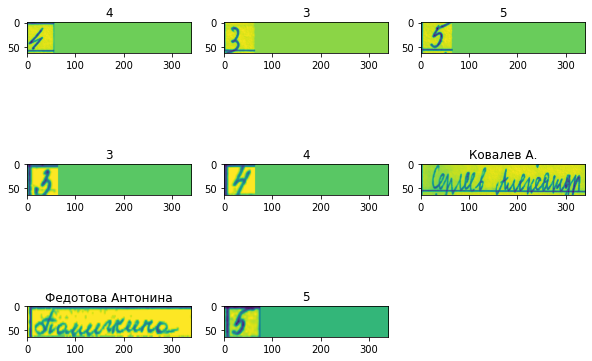

In [ ]:
examples = []
idx = 0

for batch in mix_journal_loader_train:
    img, true_label = batch[0], batch[1]
    examples.append([img, true_label])
    idx += 1
    if idx == 8:
        break
fig = plt.figure(figsize=(10, 10))
rows = int(8 / 4) + 2
columns = int(8 / 8) + 2
for j, exp in enumerate(examples):
    fig.add_subplot(rows, columns, j + 1)
    plt.imshow(exp[0][0].permute(1, 2, 0)[...,0])
    plt.title(exp[1][0])

In [ ]:
model = Model3(256, len(ALPHABET) + 1).to(DEVICE)
model.load_state_dict(torch.load('/content/drive/MyDrive/JOURNAL_HCR_PROJECT/training_results/2022-04-03_06_23_57/crnn.pth'))

<All keys matched successfully>

In [ ]:
for name, child in model.named_children():
    print(name)

conv0
conv1
conv2
conv3
conv4
conv5
conv6
pool0
pool1
pool3
pool5
bn2
bn4
bn6
relu
rnn


In [ ]:
untrainable_list = ['conv0', 'conv1', 'conv2', 'pool0', 'pool1', 'bn2']

In [ ]:
for layer_name in untrainable_list:
    for param in model.__getattr__(layer_name).parameters():
        param.requires_grad = False

In [ ]:
tokens = []
for img, target in mix_journal_dataset_train:
    tokens += list(target)

weights, _ = get_weights(tokens, ALPHABET, default_weight = 0.5)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = LRATE)
ctc_loss = CustomCTCLoss()
focal_loss = FocalLoss(weight=torch.tensor(weights))

In [ ]:
report_journal = fit(model, optimizer, ctc_loss, focal_loss, mix_journal_loader_train, mix_journal_loader_val, epochs = 120)

epoch | mean loss | mean cer | mean wer | mean val_cer | mean val_wer | time elapsed | warnings
00       3.225       0.638       0.808       0.726       0.899       12.4
01       3.198       0.623       0.807       0.737       0.907       12.7
02       3.144       0.613       0.802       0.733       0.911       12.7
03       3.181       0.631       0.807       0.728       0.905       12.6
04       3.173       0.616       0.802       0.726       0.912       12.7
05       3.105       0.618       0.792       0.741       0.921       13.7
06       3.106       0.599       0.786       0.746       0.915       12.9


KeyboardInterrupt: ignored

## TEST

In [ ]:
test_dataset = OCRdataset(PATH_TO_TEST_, PATH_TO_TEST_LABELS, transform_list = transform_list)
collator = Collator()
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 2, collate_fn = collator)
evaluate(model, test_loader)

(0.7688266331355826, 0.9961139906373057)

In [ ]:
ls /content/HTR_dataset/

 chars_code.csv         grades_data.zip       test.tsv
 gen_source.txt         Names_test_dataset/   train_filtered.csv
 gen_source_valid.txt   test_journal/         train.tsv
'Grades Dataset'/       test_journal.zip


In [ ]:
def predict(model, img):
    model.eval()
    with torch.no_grad():
        logits = model(img.to(DEVICE))
        logits = logits.contiguous().cpu()
        T, B, H = logits.size()
        pred_sizes = torch.LongTensor([T for i in range(B)])
        probs, pos = logits.max(2)
        pos = pos.transpose(1, 0).contiguous().view(-1)
        sim_preds = coder.decode(pos.data, pred_sizes.data, raw=False)
        return sim_preds

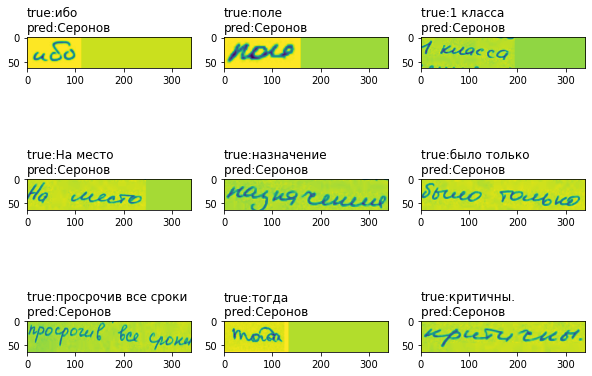

In [ ]:
examples = []
idx = 0
coder = LabelCoder(ALPHABET)
model.eval()
with torch.no_grad():
    for batch in test_loader:
        img, true_label = batch['img'], batch['label']
        pred_label = predict(model, img)
        examples.append([img, true_label, pred_label])
        idx += 1
        if idx == 9:
            break
fig = plt.figure(figsize=(10, 10))
rows = int(9 / 4) + 2
columns = int(9 / 8) + 2
for j, exp in enumerate(examples):
    fig.add_subplot(rows, columns, j + 1)
    plt.imshow(exp[0][0].permute(1, 2, 0)[...,0])
    plt.title('true:' + exp[1][0] + '\npred:' + exp[2][0], loc = 'left')

In [ ]:
evaluate(model, val_names_loader)

(0.768111646917297, 1.000000001)

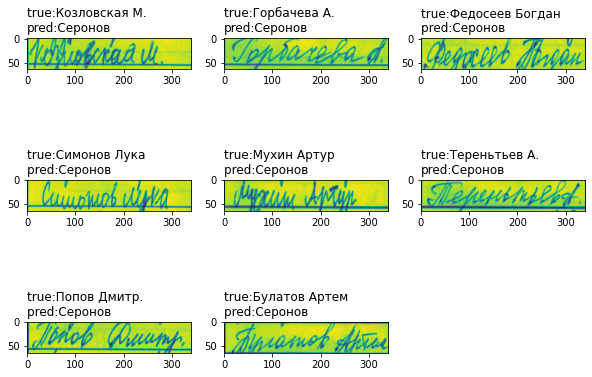

In [ ]:
examples = []
idx = 0
model.eval()
with torch.no_grad():
  for batch in val_names_loader:
      img, true_label = batch['img'], batch['label']
      pred_label = predict(model, img)
      examples.append([img, true_label, pred_label])
      idx += 1
      if idx == 9:
          break
fig = plt.figure(figsize=(10, 10))
rows = int(9 / 4) + 2
columns = int(9 / 8) + 2
for j, exp in enumerate(examples):
    fig.add_subplot(rows, columns, j + 1)
    plt.imshow(exp[0][0].permute(1, 2, 0)[...,0])
    plt.title('true:' + exp[1][0] + '\npred:' + exp[2][0], loc = 'left')

## Grades Test


In [ ]:
grades_val_cer, grades_val_wer = evaluate(model, val_grades_loader)
print(grades_val_cer, grades_val_wer)

0.738955823638555 0.751004017064257


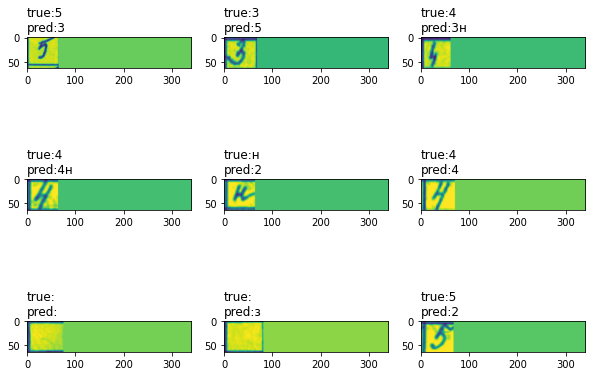

In [ ]:
examples = []
idx = 0
model.eval()
with torch.no_grad():
  for batch in val_grades_loader:
      img, true_label = batch[0], batch[1]
      pred_label = predict(model, img)
      examples.append([img, true_label, pred_label])
      idx += 1
      if idx == 9:
          break
fig = plt.figure(figsize=(10, 10))
rows = int(9 / 4) + 2
columns = int(9 / 8) + 2
for j, exp in enumerate(examples):
    fig.add_subplot(rows, columns, j + 1)
    plt.imshow(exp[0][0].permute(1, 2, 0)[...,0])
    plt.title('true:' + exp[1][0] + '\npred:' + exp[2][0], loc = 'left')